# Implementing DOLCE algorithm

# 1. Train the conditional denoiser

## Load Data

In [1]:
!pip install deepinv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.7/187.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00
  Created wheel for runstats: filename=runstats-2.0.0-py3-none-a

In [2]:
import deepinv as dinv
from torch.utils.data import DataLoader
import torch
from pathlib import Path
from torchvision import transforms, datasets
from deepinv.training_utils import train, test

### Setup paths for data loading and results

In [3]:
import deepinv as dinv
from torch.utils.data import DataLoader
import torch
from pathlib import Path
from torchvision import transforms, datasets
from deepinv.training_utils import train, test
from torch.utils.data import Subset

BASE_DIR = Path(".")
ORIGINAL_DATA_DIR = BASE_DIR / "datasets"
DATA_DIR = BASE_DIR / "measurements"
RESULTS_DIR = BASE_DIR / "results"
DEG_DIR = BASE_DIR / "degradations"
CKPT_DIR = BASE_DIR / "ckpts"


# delete the measurements and results directories
import shutil

if DATA_DIR.exists():
    shutil.rmtree(DATA_DIR)
if RESULTS_DIR.exists():
    shutil.rmtree(RESULTS_DIR)

# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")



operation = "denoise"
train_dataset_name = "CIFAR10"

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(32)])

train_dataset = datasets.CIFAR10(
    root="../datasets/", train=True, transform=transform, download=True
)
test_dataset = datasets.CIFAR10(
    root="../datasets/", train=False, transform=transform, download=True
)

fraction = 0.2  # fraction des échantillons à conserver (1/10 dans ce cas)
num_samples = len(train_dataset)
num_samples_to_keep = int(fraction * num_samples)

subset_indices = list(range(num_samples_to_keep))
train_dataset = Subset(train_dataset, subset_indices)

Using device: cpu


100%|██████████| 170498071/170498071 [00:01<00:00, 99244376.98it/s] 


Extracting ../datasets/cifar-10-python.tar.gz to ../datasets/
Files already downloaded and verified


In [ ]:
BASE_DIR = Path(".")
ORIGINAL_DATA_DIR = BASE_DIR / "data"
DATA_DIR = BASE_DIR
RESULTS_DIR = BASE_DIR / "results"
# DEG_DIR = BASE_DIR / "degradations"
CKPT_DIR = BASE_DIR / "ckpts"

# # delete the measurements and results directories
# import shutil

# if DATA_DIR.exists():
#     shutil.rmtree(DATA_DIR)
# if RESULTS_DIR.exists():
#     shutil.rmtree(RESULTS_DIR)

# # Set the global random seed from pytorch to ensure reproducibility of the example.
# torch.manual_seed(0)

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Selected GPU 0 with 13593 MB free memory 
Using device: cuda:0


### Load base image datasets

In [ ]:
physics = dinv.physics.Tomography(
    img_width=32,
    angles=60, # i don't know how to change it and if it is relevant or not
    circle=False,
    device=device,
    noise_model=dinv.physics.GaussianNoise(0.1),
)

# Use parallel dataloader if using a GPU to fasten training,
# otherwise, as all computes are on CPU, use synchronous data loading.
num_workers = 4 if torch.cuda.is_available() else 0
dataset_name = "CIFAR10_4"
operation = "tomography"
measurement_dir = DATA_DIR / dataset_name / operation
dinv_dataset_path = dinv.datasets.generate_dataset(
    train_dataset=train_dataset,
    test_dataset=None,
    physics=physics,
    device=device,
    save_dir=measurement_dir,
    num_workers=num_workers,
)

train_dataset = dinv.datasets.HDF5Dataset(path=dinv_dataset_path, train=True)




Computing train measurement vectors from base dataset...


100%|██████████| 2/2 [01:03<00:00, 31.92s/it]

Dataset has been saved in CIFAR10_4/tomography


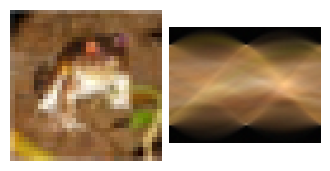

In [ ]:
# display an image from the base dataset
x_train, y_train = train_dataset[0]
dinv.utils.plot([x_train.unsqueeze(0), y_train.unsqueeze(0)])

### Generate a dataset of measurements using tomography

In [ ]:
print(test_dataset[0][0].shape)

torch.Size([3, 32, 32])


In [ ]:
print("Training dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))
print("Image size:", x_train.shape)
print("Measurement size:", y_train.shape)

Training dataset size: 10000
Test dataset size: 10000
Image size: torch.Size([3, 32, 32])
Measurement size: torch.Size([3, 46, 60])


### Create dataloader

In [ ]:
batch_size = 16

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

# test_dataloader = DataLoader(
#     test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
# )

### Set up the denoiser model


In [ ]:
# class create from the model of Artifacts removal
import torch
import torch.nn as nn

class ConditionalDenoiser(nn.Module):
    r"""
    Conditional denoiser network

    :param torch.nn.Module backbone_net: Base network :math:`\phi`, can be pretrained or not.
    :param bool pinv: If ``True`` uses pseudo-inverse :math:`A^{\dagger}y` instead of the default transpose.
    :param torch.device device: cpu or gpu.
    """

    def __init__(self, backbone_net, pinv=False, ckpt_path=None, device=None):
        super(ConditionalDenoiser, self).__init__()
        self.pinv = pinv
        self.backbone_net = backbone_net

        if ckpt_path is not None:
            self.backbone_net.load_state_dict(torch.load(ckpt_path), strict=True)
            self.backbone_net.eval()

        if type(self.backbone_net).__name__ == "UNetRes":
            for _, v in self.backbone_net.named_parameters():
                v.requires_grad = False
            self.backbone_net = self.backbone_net.to(device)

    def forward(self, x, sigma, c, **kwargs): # put x, sigma and c into the forward
        r"""
        Reconstructs a signal estimate from measurements y using the condition

        :param torch.tensor y: measurements
        :param deepinv.physics.Physics physics: forward operator
        """
        xp = torch.cat([c, x], dim=1)

        return self.backbone_net(xp, sigma)


### Training loop

In [ ]:
# create the model
model = ConditionalDenoiser(
    backbone_net=dinv.models.UNet(
    in_channels=6, # because of the condition
    out_channels=3
)).to(device)  # we can use different models here, for example, UNet with attention as in the paper or with residual blocks


In [ ]:
import torchvision.utils
from deepinv.utils import (
    save_model,
    AverageMeter,
    get_timestamp,
    cal_psnr,
)
from deepinv.utils import plot, plot_curves, wandb_plot_curves, rescale_img, zeros_like
import numpy as np
from tqdm import tqdm
import torch
import wandb
from pathlib import Path


def train(
    model,
    train_dataloader,
    epochs,
    losses,
    eval_dataloader=None,
    physics=None,
    optimizer=None,
    grad_clip=None,
    scheduler=None,
    device="cpu",
    ckp_interval=1,
    eval_interval=1,
    save_path=".",
    verbose=False,
    unsupervised=False,
    plot_images=False,
    plot_metrics=False,
    wandb_vis=False,
    wandb_setup={},
    online_measurements=False,
    plot_measurements=True,
    check_grad=False,
    ckpt_pretrained=None,
    fact_losses=None,
    freq_plot=1,
):
    r"""
    Trains a reconstruction network.


    .. note::

        The losses can be chosen from :ref:`the libraries' training losses <loss>`, or can be a custom loss function,
        as long as it takes as input ``(x, x_net, y, physics, model)`` and returns a scalar, where ``x`` is the ground
        reconstruction, ``x_net`` is the network reconstruction :math:`\inversef{y, A}`,
        ``y`` is the measurement vector, ``physics`` is the forward operator
        and ``model`` is the reconstruction network. Note that not all inpus need to be used by the loss,
        e.g., self-supervised losses will not make use of ``x``.


    :param torch.nn.Module, deepinv.models.ArtifactRemoval model: Reconstruction network, which can be PnP, unrolled, artifact removal
        or any other custom reconstruction network.
    :param torch.utils.data.DataLoader train_dataloader: Train dataloader.
    :param int epochs: Number of training epochs.
    :param torch.nn.Module, list of torch.nn.Module losses: Loss or list of losses used for training the model.
    :param torch.utils.data.DataLoader eval_dataloader: Evaluation dataloader.
    :param deepinv.physics.Physics, list[deepinv.physics.Physics] physics: Forward operator(s)
        used by the reconstruction network at train time.
    :param torch.nn.optim optimizer: Torch optimizer for training the network.
    :param float grad_clip: Gradient clipping value for the optimizer. If None, no gradient clipping is performed.
    :param torch.nn.optim scheduler: Torch scheduler for changing the learning rate across iterations.
    :param torch.device device: gpu or cpu.
    :param int ckp_interval: The model is saved every ``ckp_interval`` epochs.
    :param int eval_interval: Number of epochs between each evaluation of the model on the evaluation set.
    :param str save_path: Directory in which to save the trained model.
    :param bool verbose: Output training progress information in the console.
    :param bool unsupervised: Train an unsupervised network, i.e., uses only measurement vectors y for training.
    :param bool plot_images: Plots reconstructions every ``ckp_interval`` epochs.
    :param bool wandb_vis: Use Weights & Biases visualization, see https://wandb.ai/ for more details.
    :param dict wandb_setup: Dictionary with the setup for wandb, see https://docs.wandb.ai/quickstart for more details.
    :param bool online_measurements: Generate the measurements in an online manner at each iteration by calling
         ``physics(x)``. This results in a wider range of measurements if the physics' parameters, such as
         parameters of the forward operator or noise realizations, can change between each sample; these are updated
         with the ``physics.reset()`` method. If ``online_measurements=False``, the measurements are loaded from the training dataset
    :param bool plot_measurements: Plot the measurements y. default=True.
    :param bool check_grad: Check the gradient norm at each iteration.
    :param str ckpt_pretrained: path of the pretrained checkpoint. If None, no pretrained checkpoint is loaded.
    :param list fact_losses: List of factors to multiply the losses. If None, all losses are multiplied by 1.
    :param int freq_plot: Frequency of plotting images to wandb. If 1, plots at each epoch.
    :returns: Trained model.
    """
    save_path = Path(save_path)

    # wandb initialiation
    if wandb_vis:
        if wandb.run is None:
            wandb.init(**wandb_setup)

    # set the different metrics
    meters = []
    total_loss = AverageMeter("loss", ":.2e")
    meters.append(total_loss)
    if not isinstance(losses, list) or isinstance(losses, tuple):
        losses = [losses]
    if fact_losses is None:
        fact_losses = [1] * len(losses)
    losses_verbose = [AverageMeter("Loss_" + l.name, ":.2e") for l in losses]
    for loss in losses_verbose:
        meters.append(loss)
    train_psnr = AverageMeter("Train_psnr_model", ":.2f")
    meters.append(train_psnr)
    if eval_dataloader:
        eval_psnr = AverageMeter("Eval_psnr_model", ":.2f")
        meters.append(eval_psnr)
    if check_grad:
        check_grad_val = AverageMeter("Gradient norm", ":.2e")
        meters.append(check_grad_val)

    save_path = f"{save_path}/{get_timestamp()}"

    # count the overall training parameters
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"The model has {params} trainable parameters")

    # make physics and data_loaders of list type
    if type(physics) is not list:
        physics = [physics]
    if type(train_dataloader) is not list:
        train_dataloader = [train_dataloader]
    if eval_dataloader and type(eval_dataloader) is not list:
        eval_dataloader = [eval_dataloader]

    G = len(train_dataloader)

    loss_history = []

    log_dict = {}

    epoch_start = 0
    if ckpt_pretrained is not None:
        checkpoint = torch.load(ckpt_pretrained)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        epoch_start = checkpoint["epoch"]

    for epoch in range(epoch_start, epochs):
        ### Evaluation

        if wandb_vis:
            wandb_log_dict_epoch = {"epoch": epoch}

        # perform evaluation every eval_interval epoch
        perform_eval = (
            (not unsupervised)
            and eval_dataloader
            and ((epoch + 1) % eval_interval == 0 or epoch + 1 == epochs)
        )

        if perform_eval:
            test_psnr, _, _, _ = test(
                model,
                eval_dataloader,
                physics,
                device,
                verbose=False,
                plot_images=plot_images,
                plot_metrics=plot_metrics,
                wandb_vis=wandb_vis,
                wandb_setup=wandb_setup,
                step=epoch,
                online_measurements=online_measurements,
            )
            eval_psnr.update(test_psnr)
            log_dict["eval_psnr"] = test_psnr
            if wandb_vis:
                wandb_log_dict_epoch["eval_psnr"] = test_psnr

        # wandb logging
        if wandb_vis:
            last_lr = None if scheduler is None else scheduler.get_last_lr()[0]
            wandb_log_dict_epoch["learning rate"] = last_lr

            wandb.log(wandb_log_dict_epoch)

        ### Training

        model.train()

        for meter in meters:
            meter.reset()  # reset the metric at each epoch

        iterators = [iter(loader) for loader in train_dataloader]
        batches = len(train_dataloader[G - 1])

        noise_module = dinv.physics.UniformGaussianNoise()

        for i in (progress_bar := tqdm(range(batches), disable=not verbose)):
            progress_bar.set_description(f"Epoch {epoch + 1}")

            if wandb_vis:
                wandb_log_dict_iter = {}

            # random permulation of the dataloaders
            G_perm = np.random.permutation(G)

            for g in G_perm:  # for each dataloader
                if online_measurements:  # the measurements y are created on-the-fly
                    x, _ = next(
                        iterators[g]
                    )  # In this case the dataloader outputs also a class label
                    x = x.to(device)
                    physics_cur = physics[g]

                    if isinstance(physics_cur, torch.nn.DataParallel):
                        physics_cur.module.noise_model.__init__()
                    else:
                        physics_cur.reset()

                    y = physics_cur(x) # a check

                else:  # the measurements y were pre-computed
                    if unsupervised:
                        y = next(iterators[g])
                        x = None
                    else:
                        x, y = next(iterators[g])
                        if type(x) is list or type(x) is tuple:
                            x = [s.to(device) for s in x]
                        else:
                            x = x.to(device)

                    physics_cur = physics[g]

                y = y.to(device)

                optimizer.zero_grad()



                x_noisy = noise_module(x)


                # c = physics_cur.A_adjoint(y) if not model.pinv else physics_cur.A_dagger(y)
                c = physics_cur.A_adjoint(y)
                # run the forward model
                x_net = model(x_noisy, noise_module.sigma, c) # put xp c and sigma into the model
                if i % 500 == 0:
                  print(noise_module.sigma[0,:,:,:], x_noisy.shape)
                  plot([x[:1,:,:,:], x_noisy[:1,:,:,:], c[:1,:,:,:], x_net[:1,:,:,:]], ["x", "x_noisy", "c", "x_net"])
                  for x_ in [x, x_noisy, c, x_net]:
                    print(torch.max(x_).item(), torch.min(x_).item(), x_.shape)

                # compute the losses
                loss_total = 0
                for k, l in enumerate(losses):
                    loss = l(x=x, x_net=x_net, y=y, physics=physics[g], model=model)
                    loss_total += fact_losses[k] * loss
                    losses_verbose[k].update(loss.item())
                    if len(losses) > 1:
                        log_dict["loss_" + l.name] = losses_verbose[k].avg
                        if wandb_vis:
                            wandb_log_dict_iter["loss_" + l.name] = loss.item()
                if wandb_vis:
                    wandb_log_dict_iter["training loss"] = loss_total.item()
                total_loss.update(loss_total.item())
                log_dict["total_loss"] = total_loss.avg

                # backward the total loss
                loss_total.backward()

                # gradient clipping
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                if check_grad:
                    # from https://discuss.pytorch.org/t/check-the-norm-of-gradients/27961/7
                    grads = [
                        param.grad.detach().flatten()
                        for param in model.parameters()
                        if param.grad is not None
                    ]
                    norm_grads = torch.cat(grads).norm()
                    wandb_log_dict_iter["gradient norm"] = norm_grads.item()
                    check_grad_val.update(norm_grads.item())

                # optimize step
                optimizer.step()

                # training psnr and logging
                if not unsupervised:
                    with torch.no_grad():
                        psnr = cal_psnr(x_net, x)
                        train_psnr.update(psnr)
                        if wandb_vis:
                            wandb_log_dict_iter["train_psnr"] = psnr
                            wandb.log(wandb_log_dict_iter)
                        log_dict["train_psnr"] = train_psnr.avg

                progress_bar.set_postfix(log_dict)

        # wandb plotting of training images
        if wandb_vis:
            # log average training metrics
            log_dict_post_epoch = {}
            log_dict_post_epoch["mean training loss"] = total_loss.avg
            log_dict_post_epoch["mean training psnr"] = train_psnr.avg
            if check_grad:
                log_dict_post_epoch["mean gradient norm"] = check_grad_val.avg

            with torch.no_grad():
                if plot_measurements and y.shape != x.shape:
                    y_reshaped = torch.nn.functional.interpolate(y, size=x.shape[2])
                    if hasattr(physics_cur, "A_adjoint"):
                        imgs = [y_reshaped, physics_cur.A_adjoint(y), x_net, x]
                        caption = (
                            "From top to bottom: input, backprojection, output, target"
                        )
                    else:
                        imgs = [y_reshaped, x_net, x]
                        caption = "From top to bottom: input, output, target"
                else:
                    if hasattr(physics_cur, "A_adjoint"):
                        if isinstance(physics_cur, torch.nn.DataParallel):
                            back = physics_cur.module.A_adjoint(y)
                        else:
                            back = physics_cur.A_adjoint(y)
                        imgs = [back, x_net, x]
                        caption = "From top to bottom: backprojection, output, target"
                    else:
                        imgs = [x_net, x]
                        caption = "From top to bottom: output, target"

                vis_array = torch.cat(imgs, dim=0)
                for i in range(len(vis_array)):
                    vis_array[i] = rescale_img(vis_array[i], rescale_mode="min_max")
                grid_image = torchvision.utils.make_grid(vis_array, nrow=y.shape[0])
                if epoch % freq_plot == 0:
                    images = wandb.Image(
                        grid_image,
                        caption=caption,
                    )
                    log_dict_post_epoch["Training samples"] = images

        if wandb_vis:
            wandb.log(log_dict_post_epoch)

        loss_history.append(total_loss.avg)

        if scheduler:
            scheduler.step()

        # Saving the model
        save_model(
            epoch,
            model,
            optimizer,
            ckp_interval,
            epochs,
            loss_history,
            str(save_path),
            eval_psnr=eval_psnr if perform_eval else None,
        )

    if wandb_vis:
        wandb.save("model.h5")

    return model



The model has 8565891 trainable parameters


Epoch 1:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


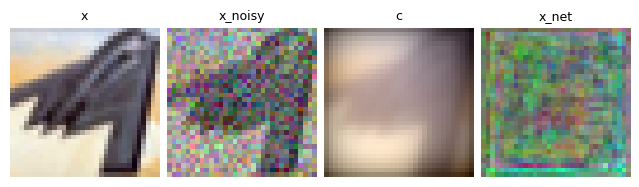

Epoch 1:   0%|          | 1/10000 [00:00<1:51:00,  1.50it/s, total_loss=0.446, train_psnr=3.76]

0.9921568632125854 0.0313725508749485 torch.Size([1, 3, 32, 32])
1.6316977739334106 -0.4296529293060303 torch.Size([1, 3, 32, 32])
35.18381881713867 16.475223541259766 torch.Size([1, 3, 32, 32])
1.6585193872451782 -1.4838435649871826 torch.Size([1, 3, 32, 32])


Epoch 1:   5%|▌         | 500/10000 [00:27<11:40, 13.57it/s, total_loss=0.0323, train_psnr=16.6]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


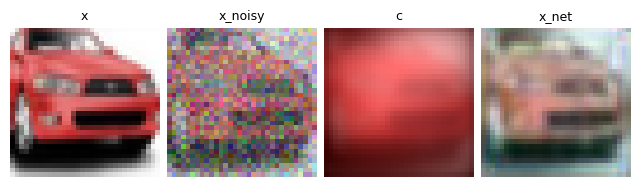

Epoch 1:   5%|▌         | 502/10000 [00:28<20:30,  7.72it/s, total_loss=0.0323, train_psnr=16.6]

1.0 0.0 torch.Size([1, 3, 32, 32])
1.5660722255706787 -0.6530572175979614 torch.Size([1, 3, 32, 32])
35.42591857910156 11.233017921447754 torch.Size([1, 3, 32, 32])
1.1204789876937866 -0.1748761385679245 torch.Size([1, 3, 32, 32])


Epoch 1:  10%|█         | 1000/10000 [00:55<09:45, 15.38it/s, total_loss=0.026, train_psnr=17.4]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


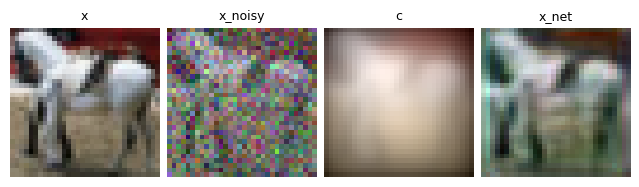

Epoch 1:  10%|█         | 1002/10000 [00:55<18:23,  8.15it/s, total_loss=0.0259, train_psnr=17.4]

1.0 0.13725490868091583 torch.Size([1, 3, 32, 32])
1.6553115844726562 -0.3869292736053467 torch.Size([1, 3, 32, 32])
32.8084602355957 12.966470718383789 torch.Size([1, 3, 32, 32])
1.0233100652694702 0.06937074661254883 torch.Size([1, 3, 32, 32])


Epoch 1:  15%|█▍        | 1499/10000 [01:22<07:50, 18.06it/s, total_loss=0.0225, train_psnr=18]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


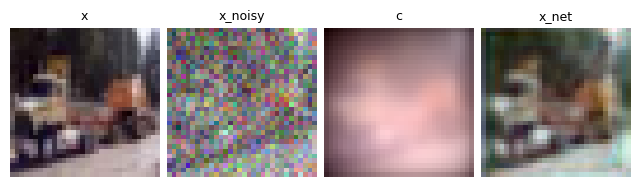

Epoch 1:  15%|█▌        | 1503/10000 [01:23<13:04, 10.83it/s, total_loss=0.0225, train_psnr=18]

1.0 0.13333334028720856 torch.Size([1, 3, 32, 32])
1.4564437866210938 -0.5768654346466064 torch.Size([1, 3, 32, 32])
27.17916488647461 10.35502815246582 torch.Size([1, 3, 32, 32])
1.1050583124160767 0.017384318634867668 torch.Size([1, 3, 32, 32])


Epoch 1:  20%|██        | 2000/10000 [01:50<07:48, 17.08it/s, total_loss=0.0206, train_psnr=18.4]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


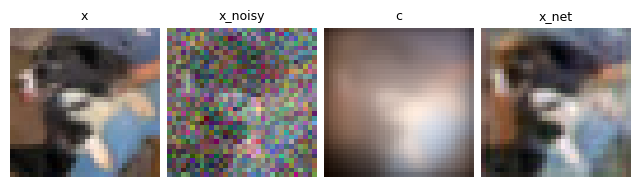

Epoch 1:  20%|██        | 2002/10000 [01:51<14:15,  9.35it/s, total_loss=0.0206, train_psnr=18.4]

0.8666666746139526 0.01568627543747425 torch.Size([1, 3, 32, 32])
1.4627400636672974 -0.48474055528640747 torch.Size([1, 3, 32, 32])
24.228580474853516 8.086329460144043 torch.Size([1, 3, 32, 32])
1.0399518013000488 -0.023531273007392883 torch.Size([1, 3, 32, 32])


Epoch 1:  25%|██▌       | 2500/10000 [02:20<05:47, 21.61it/s, total_loss=0.019, train_psnr=18.7]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


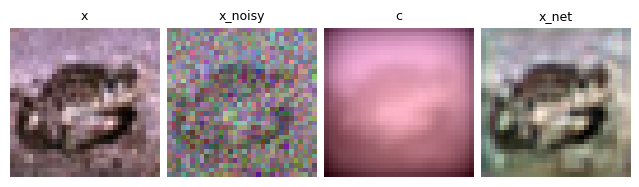

Epoch 1:  25%|██▌       | 2503/10000 [02:20<09:03, 13.79it/s, total_loss=0.019, train_psnr=18.7]

0.9411764740943909 0.019607843831181526 torch.Size([1, 3, 32, 32])
1.614929437637329 -0.7047324776649475 torch.Size([1, 3, 32, 32])
28.352760314941406 11.369150161743164 torch.Size([1, 3, 32, 32])
1.0110458135604858 -0.018301578238606453 torch.Size([1, 3, 32, 32])


Epoch 1:  30%|███       | 3000/10000 [02:48<04:59, 23.35it/s, total_loss=0.0178, train_psnr=19]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


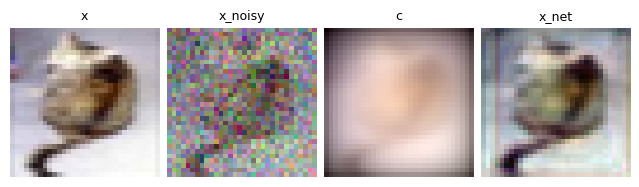

Epoch 1:  30%|███       | 3003/10000 [02:48<08:01, 14.54it/s, total_loss=0.0178, train_psnr=19]

0.95686274766922 0.0941176488995552 torch.Size([1, 3, 32, 32])
1.6678109169006348 -0.43194302916526794 torch.Size([1, 3, 32, 32])
36.84526062011719 18.448787689208984 torch.Size([1, 3, 32, 32])
1.0229151248931885 -0.01714632660150528 torch.Size([1, 3, 32, 32])


Epoch 1:  35%|███▌      | 3500/10000 [03:18<06:25, 16.84it/s, total_loss=0.017, train_psnr=19.2]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


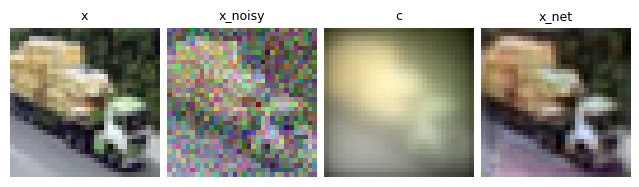

Epoch 1:  35%|███▌      | 3502/10000 [03:19<12:27,  8.69it/s, total_loss=0.017, train_psnr=19.2]

0.9843137264251709 0.05882352963089943 torch.Size([1, 3, 32, 32])
1.4187074899673462 -0.46053892374038696 torch.Size([1, 3, 32, 32])
30.828937530517578 10.723145484924316 torch.Size([1, 3, 32, 32])
1.028124213218689 0.07689204812049866 torch.Size([1, 3, 32, 32])


Epoch 1:  40%|███▉      | 3999/10000 [03:48<05:47, 17.25it/s, total_loss=0.0163, train_psnr=19.4]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


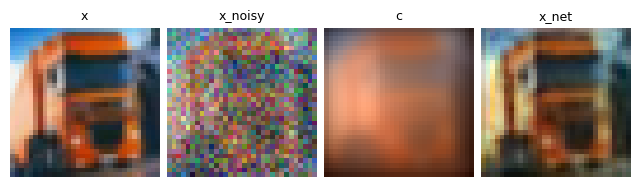

Epoch 1:  40%|████      | 4003/10000 [03:49<10:51,  9.20it/s, total_loss=0.0163, train_psnr=19.4]

0.9764705896377563 0.019607843831181526 torch.Size([1, 3, 32, 32])
1.5063204765319824 -0.5042155981063843 torch.Size([1, 3, 32, 32])
30.130836486816406 9.478976249694824 torch.Size([1, 3, 32, 32])
1.1357511281967163 -0.028580285608768463 torch.Size([1, 3, 32, 32])


Epoch 1:  45%|████▌     | 4500/10000 [04:20<05:27, 16.79it/s, total_loss=0.0156, train_psnr=19.6]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


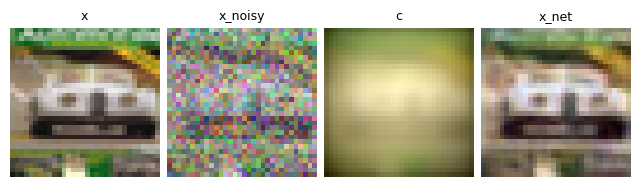

Epoch 1:  45%|████▌     | 4502/10000 [04:20<09:57,  9.20it/s, total_loss=0.0156, train_psnr=19.6]

0.9529411792755127 0.05882352963089943 torch.Size([1, 3, 32, 32])
1.3621472120285034 -0.5631399154663086 torch.Size([1, 3, 32, 32])
31.039548873901367 11.074077606201172 torch.Size([1, 3, 32, 32])
0.8734610080718994 0.020689692348241806 torch.Size([1, 3, 32, 32])


Epoch 1:  50%|████▉     | 4999/10000 [04:50<05:16, 15.82it/s, total_loss=0.015, train_psnr=19.7]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


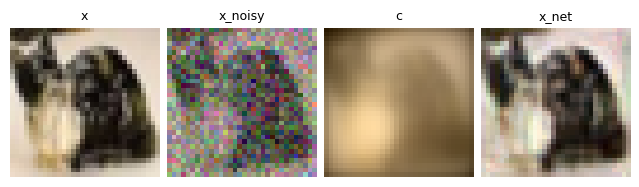

Epoch 1:  50%|█████     | 5003/10000 [04:51<08:33,  9.74it/s, total_loss=0.015, train_psnr=19.7]

0.9686274528503418 0.0 torch.Size([1, 3, 32, 32])
1.6893620491027832 -0.495510995388031 torch.Size([1, 3, 32, 32])
31.660167694091797 11.175605773925781 torch.Size([1, 3, 32, 32])
1.0080974102020264 0.05790998041629791 torch.Size([1, 3, 32, 32])


Epoch 1:  55%|█████▌    | 5500/10000 [05:22<03:28, 21.63it/s, total_loss=0.0145, train_psnr=19.9]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


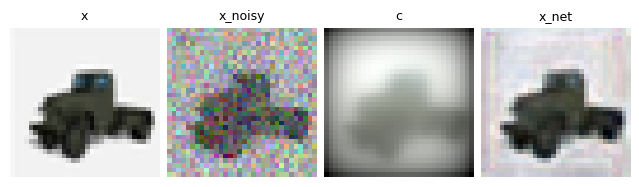

Epoch 1:  55%|█████▌    | 5503/10000 [05:22<08:26,  8.87it/s, total_loss=0.0145, train_psnr=19.9]

0.9686274528503418 0.0784313753247261 torch.Size([1, 3, 32, 32])
1.6119120121002197 -0.47749197483062744 torch.Size([1, 3, 32, 32])
40.87693405151367 23.26152229309082 torch.Size([1, 3, 32, 32])
1.0168464183807373 0.060878947377204895 torch.Size([1, 3, 32, 32])


Epoch 1:  60%|██████    | 6000/10000 [05:46<03:37, 18.36it/s, total_loss=0.0141, train_psnr=20]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


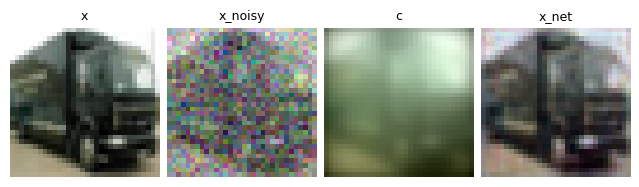

Epoch 1:  60%|██████    | 6002/10000 [05:47<07:33,  8.83it/s, total_loss=0.0141, train_psnr=20]

1.0 0.0 torch.Size([1, 3, 32, 32])
1.5518088340759277 -0.6732238531112671 torch.Size([1, 3, 32, 32])
24.405981063842773 10.295698165893555 torch.Size([1, 3, 32, 32])
1.034463882446289 -0.034777529537677765 torch.Size([1, 3, 32, 32])


Epoch 1:  65%|██████▌   | 6500/10000 [06:18<03:30, 16.65it/s, total_loss=0.0137, train_psnr=20.1]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


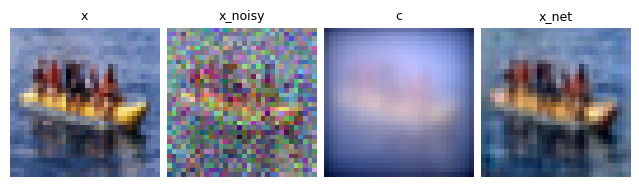

Epoch 1:  65%|██████▌   | 6502/10000 [06:19<06:44,  8.65it/s, total_loss=0.0137, train_psnr=20.1]

0.9882352948188782 0.08235294371843338 torch.Size([1, 3, 32, 32])
1.41530442237854 -0.4037313163280487 torch.Size([1, 3, 32, 32])
30.49249267578125 12.568507194519043 torch.Size([1, 3, 32, 32])
1.1217594146728516 0.05223320424556732 torch.Size([1, 3, 32, 32])


Epoch 1:  70%|██████▉   | 6999/10000 [06:50<03:20, 14.97it/s, total_loss=0.0133, train_psnr=20.3]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


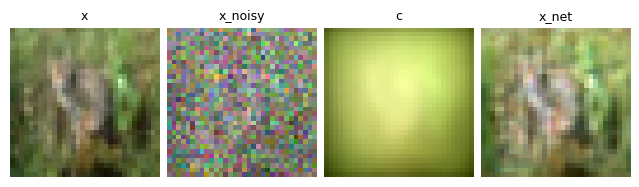

Epoch 1:  70%|███████   | 7003/10000 [06:50<04:59, 10.01it/s, total_loss=0.0133, train_psnr=20.3]

0.8235294222831726 0.03921568766236305 torch.Size([1, 3, 32, 32])
1.2603768110275269 -0.5715974569320679 torch.Size([1, 3, 32, 32])
22.98297691345215 6.932496070861816 torch.Size([1, 3, 32, 32])
0.8341639637947083 0.0010659154504537582 torch.Size([1, 3, 32, 32])


Epoch 1:  75%|███████▍  | 7499/10000 [07:18<01:50, 22.65it/s, total_loss=0.0129, train_psnr=20.4]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


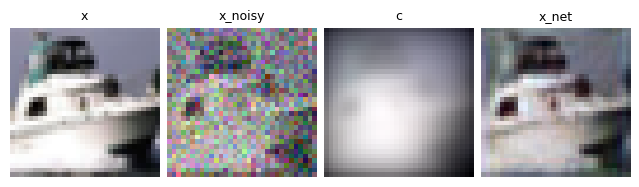

Epoch 1:  75%|███████▌  | 7504/10000 [07:18<02:43, 15.23it/s, total_loss=0.0129, train_psnr=20.4]

1.0 0.09019608050584793 torch.Size([1, 3, 32, 32])
1.5736677646636963 -0.40289172530174255 torch.Size([1, 3, 32, 32])
40.80663299560547 16.300107955932617 torch.Size([1, 3, 32, 32])
0.9579633474349976 0.04025667533278465 torch.Size([1, 3, 32, 32])


Epoch 1:  80%|███████▉  | 7999/10000 [07:47<02:03, 16.22it/s, total_loss=0.0127, train_psnr=20.5]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


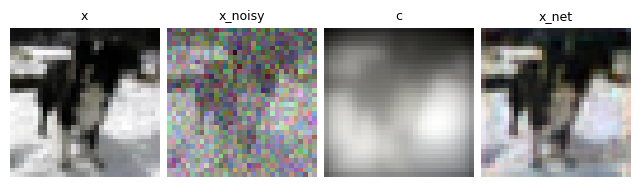

Epoch 1:  80%|████████  | 8003/10000 [07:48<03:26,  9.68it/s, total_loss=0.0127, train_psnr=20.5]

0.886274516582489 0.0 torch.Size([1, 3, 32, 32])
1.5416462421417236 -0.7987481951713562 torch.Size([1, 3, 32, 32])
27.407625198364258 9.423609733581543 torch.Size([1, 3, 32, 32])
1.0010018348693848 -0.00461796298623085 torch.Size([1, 3, 32, 32])


Epoch 1:  85%|████████▍ | 8498/10000 [08:13<01:10, 21.32it/s, total_loss=0.0124, train_psnr=20.6]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


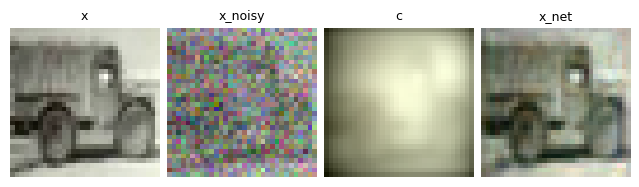

Epoch 1:  85%|████████▌ | 8504/10000 [08:14<01:36, 15.47it/s, total_loss=0.0124, train_psnr=20.6]

0.8941176533699036 0.06666667014360428 torch.Size([1, 3, 32, 32])
1.6128169298171997 -0.5813305377960205 torch.Size([1, 3, 32, 32])
29.339733123779297 14.018288612365723 torch.Size([1, 3, 32, 32])
0.9879238605499268 0.03688186779618263 torch.Size([1, 3, 32, 32])


Epoch 1:  90%|█████████ | 9000/10000 [08:45<00:55, 17.97it/s, total_loss=0.0122, train_psnr=20.7]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


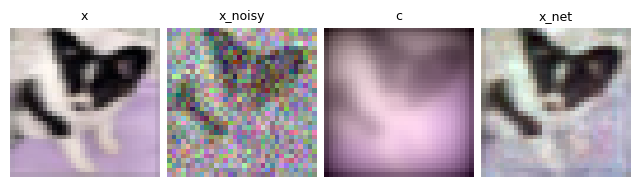

Epoch 1:  90%|█████████ | 9002/10000 [08:45<01:49,  9.10it/s, total_loss=0.0122, train_psnr=20.7]

0.8352941274642944 0.054901961237192154 torch.Size([1, 3, 32, 32])
1.3880879878997803 -0.5941497683525085 torch.Size([1, 3, 32, 32])
30.869604110717773 15.449017524719238 torch.Size([1, 3, 32, 32])
0.9699835181236267 -0.03221534937620163 torch.Size([1, 3, 32, 32])


Epoch 1:  95%|█████████▌| 9500/10000 [09:11<00:28, 17.44it/s, total_loss=0.0119, train_psnr=20.8]

tensor([[[0.2235]]], device='cuda:0') torch.Size([1, 3, 32, 32])


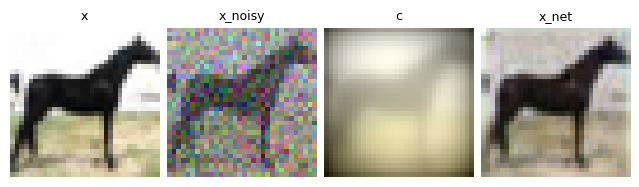

Epoch 1:  95%|█████████▌| 9502/10000 [09:11<00:58,  8.52it/s, total_loss=0.0119, train_psnr=20.8]

1.0 0.18039216101169586 torch.Size([1, 3, 32, 32])
1.7710304260253906 -0.3444420397281647 torch.Size([1, 3, 32, 32])
39.745811462402344 18.688697814941406 torch.Size([1, 3, 32, 32])
1.1557234525680542 0.11975909769535065 torch.Size([1, 3, 32, 32])


Epoch 1: 100%|██████████| 10000/10000 [09:42<00:00, 17.17it/s, total_loss=0.0117, train_psnr=20.8]


In [ ]:
import deepinv.loss as loss
import torch.optim as optim
#reduce de stepsize if the training continue to be instable

epochs = 1  # choose training epochs
learning_rate = 5e-4
T = 1000
# choose self-supervised training loss
loss = loss.SupLoss()

# choose optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(epochs * 0.8) + 1)
CKPT_DIR = "training"
trained_model = train(
    model,
    train_dataloader,
    epochs,
    loss,
    eval_dataloader=None,
    physics=physics,
    optimizer=optimizer,
    grad_clip=None,
    scheduler=scheduler,
    device=device,
    ckp_interval=1,
    eval_interval=1,
    save_path=CKPT_DIR,
    verbose=True,
    unsupervised=False,
    plot_images=False,
    plot_metrics=False,
    wandb_vis=False,
    wandb_setup={},
    online_measurements=False,
    plot_measurements=True,
    check_grad=False,
    ckpt_pretrained=None,
    fact_losses=None,
    freq_plot=1,
)

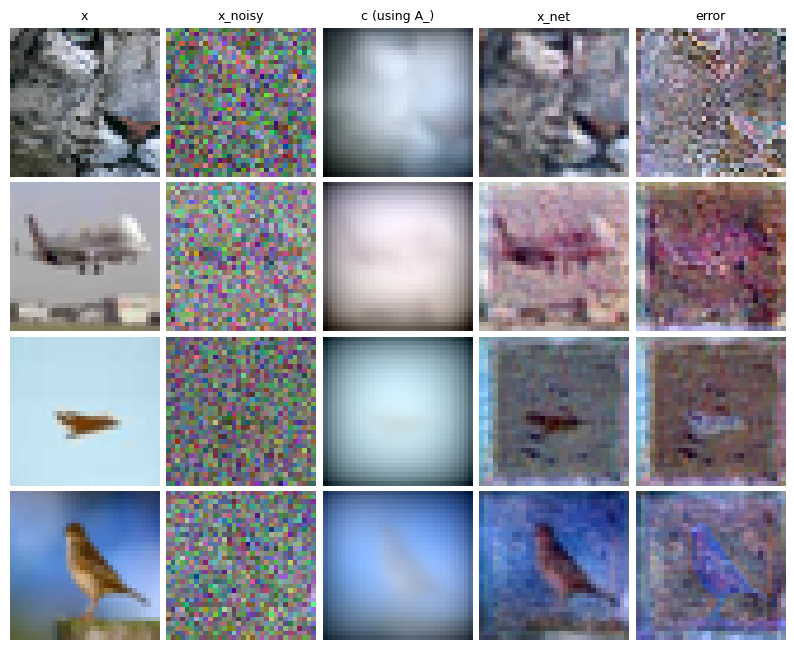

1.0 0.0 torch.Size([16, 3, 32, 32])
3.161512851715088 -1.764083743095398 torch.Size([16, 3, 32, 32])
51.6942138671875 6.774662971496582 torch.Size([16, 3, 32, 32])
1.3178120851516724 -0.22306525707244873 torch.Size([16, 3, 32, 32])


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.demo import load_url_image, get_image_url

url = "https://cdn-images.zoobeauval.com/naWDShzwEIJZuwLCd1k8uMHOOCI=/730x730/https%3A%2F%2Fs3.eu-west-3.amazonaws.com%2Fimages.zoobeauval.com%2F2020%2F06%2Fsticker-3-5ee3535a57292.jpg"

x_true = load_url_image(url=url, img_size=256, grayscale=False, device=device)

# Resize the image to 32x32
resize_transform = transforms.Compose([
    transforms.Resize((32, 32)),
])

x_true = resize_transform(x_true).to(device)
x = torch.randn((16, 3, 32, 32)).to(device)
x_panther = x_true.clone().to(device)

x, _ = train_dataset[-17:-1]
x = x.clone().to(device)
#x = torch.zeros((16, 3, 32, 32)).to(device)
x[:1, :, :, :] = x_panther


physics = dinv.physics.Tomography(
    img_width=32,
    angles=60,
    circle=False,
    device=device,
    noise_model=dinv.physics.GaussianNoise(0.2),
)

noise_module = dinv.physics.UniformGaussianNoise(sigma=0.5)
y = physics(x) # a check
y = y.to(device)
optimizer.zero_grad()
x_noisy = noise_module(x)
c = physics.A_adjoint(y)
# c = torch.randn((16, 3, 32, 32)).to(device)
x_net = model(x_noisy, noise_module.sigma, c) # put xp c and sigma into the model

plot([x, x_noisy, c, x_net, x_net - x], ["x", "x_noisy", "c (using A_)", "x_net", "error"])
for x_ in [x, x_noisy, c, x_net]:
  print(torch.max(x_).item(), torch.min(x_).item(), x_.shape)